In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium as gym
import tqdm

In [17]:
# ----------------------------
# Device setup
# ----------------------------
def get_device():
    """Select available device (CUDA, MPS for Apple, or CPU)."""
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():  # macOS Metal
        device = torch.device("mps")
    elif torch.version.hip is not None and torch.cuda.is_available():
        device = torch.device("cuda")  # AMD ROCm usually appears as CUDA device
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    return device

In [18]:
# ----------------------------
# Seeding for reproducibility
# ----------------------------
def set_seed(seed):
    """Sets seed for reproducibility across libraries and devices."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [19]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [20]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        return action_pred, value_pred

In [21]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()

In [22]:
def train_episode(env, policy, optimizer, gamma, device):
    """Train policy for one episode."""        
    policy.train()
    log_prob_actions, rewards, values, entropies = [], [], [], []
    done = False
    state, _ = env.reset()
    while not done:
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        action_pred, value_pred = policy(state)
        action_prob = F.softmax(action_pred, dim = -1)
        dist = distributions.Categorical(action_prob)
        action = dist.sample()

        next_state, reward, done, truncated, _ = env.step(action.item())
        done = done or truncated

        log_prob_actions.append(dist.log_prob(action))
        rewards.append(reward)
        values.append(value_pred.squeeze(0))
        entropies.append(dist.entropy())
        state = next_state

    log_prob_actions = torch.stack(log_prob_actions)
    values = torch.cat(values)
    entropies = torch.cat(entropies)
    returns = calculate_returns(rewards, gamma, device, False)
    advantages = calculate_advantages(returns, values, False)
    policy_loss = update_policy(advantages, log_prob_actions, returns, values, entropies, optimizer)

    return policy_loss, sum(rewards)

In [23]:
def train_batch(env, policy, optimizer, gamma, batch_size, device):
    """Collect n_episodes worth of trajectories for batch update."""
    all_log_probs, all_values, all_returns, all_entropies = [], [], [], []
    total_rewards = []
    n_episodes = batch_size
    for _ in range(n_episodes):
        log_probs, values, rewards, entropies = [], [], [], []
        done = False
        state, _ = env.reset()

        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action_logits, value_pred = policy(state_tensor)
            action_prob = F.softmax(action_logits, dim=-1)
            dist = distributions.Categorical(action_prob)
            action = dist.sample()

            next_state, reward, done, truncated, _ = env.step(action.item())
            done = done or truncated

            log_probs.append(dist.log_prob(action))
            values.append(value_pred.squeeze())
            entropies.append(dist.entropy())
            rewards.append(reward)

            state = next_state

        # Episode-level returns
        returns = calculate_returns(rewards, gamma, device)
        T = len(returns)

        all_log_probs.append(torch.stack(log_probs))
        all_values.append(torch.stack(values))
        all_entropies.append(torch.stack(entropies))
        all_returns.append(returns)
        total_rewards.append(sum(rewards))

    # Concatenate all episodes into one long batch
    log_probs = torch.cat(all_log_probs)
    values = torch.cat(all_values)
    entropies = torch.cat(all_entropies)
    returns = torch.cat(all_returns)
    advantages = calculate_advantages(returns, values);
    # advantages = (returns - values.detach())
    # advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    avg_reward = np.mean(total_rewards)
    loss = update_policy(advantages, log_probs, returns, values, entropies, optimizer)
    return loss, avg_reward

In [24]:
# ----------------------------
# Training and evaluation
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns for an episode."""
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [25]:
def calculate_advantages(returns, values, normalize = True):
    advantages = returns - values.detach()
    if normalize:
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
    return advantages

In [26]:
def update_policy(advantages, log_prob_actions, returns, values, entropies, optimizer):
    """Compute loss and update policy and value parameters."""    
    policy_loss = -(advantages * log_prob_actions).mean()
    value_loss = F.smooth_l1_loss(values, returns, reduction='mean')
    value_coef = 0.5
    entropy_coef = 0.01   
    loss = policy_loss + value_coef * value_loss - entropy_coef * entropies.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [27]:
def evaluate(env, policy, device):
    """Evaluate policy (greedy)."""        
    policy.eval()
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            action_logits, _ = policy(state_tensor)
            action = torch.argmax(F.softmax(action_logits, dim=-1)).item()
        next_state, reward, done, truncated, _ = env.step(action)
        done = done or truncated
        total_reward += reward
        state = next_state
        
    return total_reward

In [28]:
# ----------------------------
# Main experiment
# ----------------------------
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED) # Seed the environment upon reset
test_env.reset(seed=SEED+1) # Seed the environment upon reset

device_ = get_device()
# device_ = torch.device("cpu")

input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n

n_runs = 5
max_episodes = 300
discount_factor = 0.99

train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)

for run in range(n_runs):
    actor = MLP(input_dim, hidden_dim, output_dim)
    critic = MLP(input_dim, hidden_dim, 1)
    actor_critic_ = ActorCritic(actor, critic).to(device_)
    actor_critic_.apply(init_weights)
    optimizer_ = optim.Adam(actor_critic_.parameters(), lr=1e-2)
    
    for episode in tqdm.tqdm(range(max_episodes), desc=f'Run: {run}'):
        loss, train_reward = train_episode(train_env, actor_critic_, optimizer_, discount_factor, device_)
        # batch_size = 30
        # loss, train_reward = train_batch(train_env, actor_critic, optimizer, discount_factor, batch_size, device)
        test_reward = evaluate(test_env, actor_critic_, device_)
        # print(f"Iter {episode}: train reward={train_reward:.1f}, test reward={test_reward:.1f}, loss={loss:.3f}")
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward

Using device: cuda


Run: 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:10<00:00, 28.99it/s]


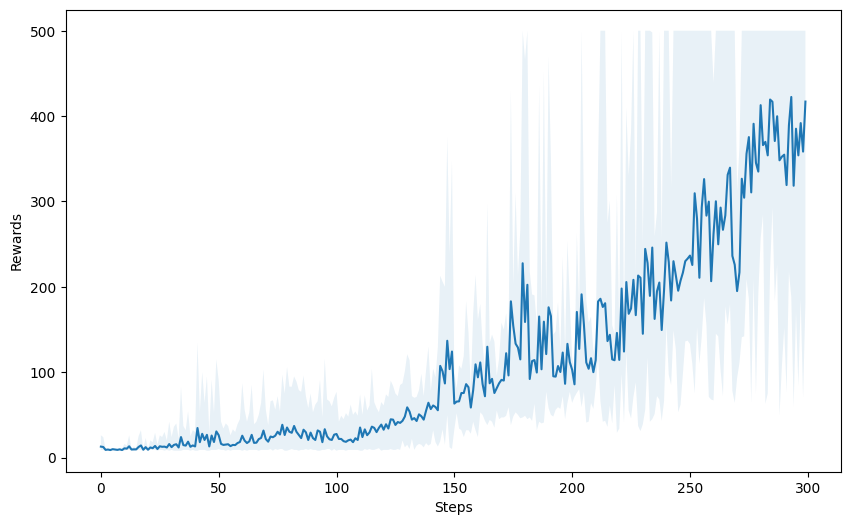

In [29]:
idxs = range(max_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, test_rewards.mean(0))
ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Steps')
ax.set_ylabel('Rewards');

In [30]:
x = torch.randn(2, 10)
y = torch.randn(2, 10)
print(F.smooth_l1_loss(x, y))
print(F.mse_loss(x, y)) 

tensor(1.1027)
tensor(3.0476)
